In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import os
import get_stock_data as gd
import pickle
import get_market_data as gmd
data = gmd.Rate_return_compile()
with open("sp500tickers.pickle", "rb") as f:
    tickers = pickle.load(f)
# there might be tickers that the web can not reach
tickers = [t for t in tickers if os.path.exists('stock_dfs/{}.csv'.format(t))]
data = data.fillna(method='ffill')
data = data.fillna(0)
np.random.seed(123)
# Turn off progress printing 
solvers.options['show_progress'] = False

                 MMM       ABT      ABBV       ACN      ATVI       AYI  \
Date                                                                     
2016-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-05 -0.004340  0.000233  0.004183 -0.005178  0.012924 -0.012533   
2016-01-06  0.020555  0.008459 -0.000174  0.001958  0.009513  0.027094   
2016-01-07  0.024970  0.024555  0.002972  0.030254  0.014337  0.027252   
2016-01-08  0.003417  0.021392  0.028032  0.009776  0.015682  0.038797   
2016-01-11  0.000214 -0.001473  0.032851 -0.010380 -0.013808  0.044346   
2016-01-12 -0.002840 -0.017607 -0.017505 -0.017622 -0.024515 -0.013294   
2016-01-13  0.015427  0.029295  0.071512  0.017630  0.064831  0.047803   
2016-01-14 -0.017425 -0.019951 -0.061950 -0.025717 -0.015254 -0.035894   
2016-01-15  0.017954  0.013814 -0.048483  0.026292  0.014036  0.019403   

                ADBE       AMD       AAP       AES    ...         WYNN  \
Date                                 

In [89]:
return_vec = data.values.T
## NUMBER OF ASSETS
n_assets = return_vec.shape[0]
## NUMBER OF OBSERVATIONS
n_obs = return_vec.shape[1]

In [90]:
# random portfolio
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio, and a filter that only allows
    the portfolio with a standard deviation smaller that 2.
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
#     if sigma > 2:
#         return random_portfolio(returns)
    return mu, sigma

In [94]:
means

array([[-0.00025318],
       [-0.00028847],
       [-0.00026507],
       [-0.00024838],
       [-0.00027461],
       [-0.00026831],
       [-0.00027049],
       [-0.00027672],
       [-0.00027545],
       [-0.00026834],
       [-0.00027902],
       [-0.00029383],
       [-0.00028872],
       [-0.00027714],
       [-0.0002604 ],
       [-0.000289  ],
       [-0.00028456],
       [-0.000229  ],
       [-0.00029513],
       [-0.00027616],
       [-0.00028487],
       [-0.00031246],
       [-0.00023005],
       [-0.00030701],
       [-0.00028459],
       [-0.00030308],
       [-0.00027554],
       [-0.00030318],
       [-0.00026488],
       [-0.00024531],
       [-0.00026981],
       [-0.00024035],
       [-0.00027297],
       [-0.00030911],
       [-0.00029778],
       [-0.00026384],
       [-0.0002594 ],
       [-0.00025594],
       [-0.00030963],
       [-0.00027609],
       [-0.00031929],
       [-0.00023308],
       [-0.00024733],
       [-0.0002962 ],
       [-0.00028794],
       [-0

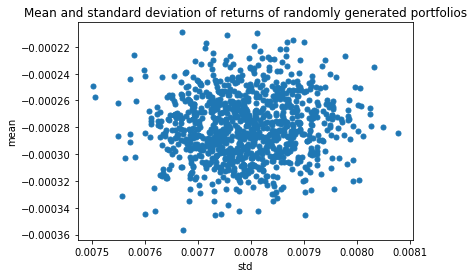

In [91]:
n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for i in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

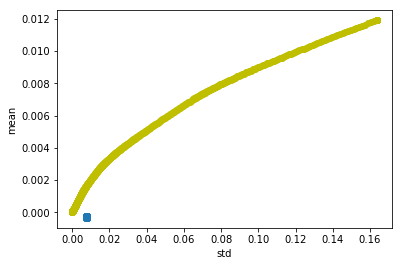

In [92]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 1000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [93]:
print(np.min(return_vec))
print(np.max(return_vec))


-0.519950782211
1.92603448276
